In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [14]:
df_raw = pd.read_csv("Data/concept2-season-2020.csv")

,ID,Date,Description,Work Time (Formatted),Work Time (Seconds),Rest Time (Formatted),Rest Time (Seconds),Work Distance,Rest Distance,Stroke Rate/Cadence,...,Avg Watts,Cal/Hour,Total Cal,Avg Heart Rate,Drag Factor,Age,Weight,Type,Ranked,Comments
0,42587184,2019-12-10 18:37:00,v1000m/1:00r...10 row,"""12:32.6""",752.6,10:00.0,600.0,3200,584.0,27,...,215,1040,219,NaN,116,26,Lwt,Indoor Rower,No,NaN
1,42587183,2019-12-09 08:43:00,5000m row,"""23:45.7""",1425.7,NaN,NaN,5000,NaN,23,...,121,715,296,NaN,111,26,Lwt,Indoor Rower,No,NaN
2,42587182,2019-12-07 14:24:00,5000m row,"""23:24.7""",1404.7,NaN,NaN,5000,NaN,22,...,126,734,308,NaN,115,26,Lwt,Indoor Rower,No,NaN
3,42587179,2019-11-29 09:07:00,10000m row,"""46:04.8""",2764.8,NaN,NaN,10000,NaN,23,...,132,755,595,NaN,113,26,Lwt,Indoor Rower,No,NaN
4,42587178,2019-11-27 09:15:00,5000m row,"""23:20.3""",1400.3,NaN,NaN,5000,NaN,23,...,127,738,307,NaN,111,26,Lwt,Indoor Rower,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,38440897,2019-05-12 14:10:00,10:02 row,"""10:02.7""",602.7,NaN,NaN,1902,NaN,17,...,88,602,100,NaN,109,26,Lwt,Indoor Rower,No,NaN
101,38440896,2019-05-12 13:57:00,3x500m/1:00r row,"""6:12.2""",372.2,3:00.0,180.0,1500,60.0,22,...,183,930,95,NaN,109,26,Lwt,Indoor Rower,No,NaN
102,38440893,2019-05-07 17:59:00,3x4:00/1:00r row,"""12:00.0""",720.0,3:00.0,180.0,2728,37.0,24,...,152,824,163,NaN,107,26,Lwt,Indoor Rower,No,NaN
103,38440890,2019-05-05 10:24:00,5:05 row,"""5:05.1""",305.1,NaN,NaN,1034,NaN,23,...,109,675,56,NaN,109,26,Lwt,Indoor Rower,No,NaN


In [13]:
# columns to drop (empty, duplicated values or constant)
col_to_drop = [
    "Stroke Count",  # empty
    "Avg Heart Rate",  # empty
    "Comments",  # empty
    "Weight",  # constant
    "Type",  # constant
    "Ranked",  # constant
    "Work Time (Formatted)",  # duplicate
    "Rest Time (Formatted)",  # duplicate
    "Age",  # constant
    "Cal/Hour",  # duplicate
]
df = df_raw.drop(col_to_drop, axis="columns")

# renaming based on preferences
dict_naming = {
    "ID": "session_id",
    "Description": "session_type",
    "Date": "session_timestamp",
    "Work Time (Seconds)": "length_work_in_s",
    "Rest Time (Seconds)": "length_rest_in_s",
    "Work Distance": "length_work_in_m",
    "Rest Distance": "length_rest_in_m",
    "Stroke Rate/Cadence": "spm",
    "Pace": "time_split",
    "Total Cal": "cal_burned",
    "Drag Factor": "drag_factor",
    "Avg Watts": "power_in_avg_w",
}
df.rename(columns=dict_naming, inplace=True)

# fill NaN values from sessions without rest with 0 (rest but equal to 0)
dict_nan = {"length_rest_in_s": 0, "length_rest_in_m": 0}
df.fillna(value=dict_nan, inplace=True)

# split date and time into two columns
df["session_timestamp"] = pd.to_datetime(df["session_timestamp"])
df["session_date"] = df["session_timestamp"].dt.date
df["session_time"] = df["session_timestamp"].dt.time
df.drop("session_timestamp", axis="columns", inplace=True)

# retrieve chrono time as the proper dtype
df["time_split"] = pd.to_datetime(df["time_split"]).dt.time

beginning: 2019-05-04 
 end: 2019-12-10


In [89]:
def create_calendar(start, end):
    start_ts = pd.to_datetime(start).date()

    end_ts = pd.to_datetime(end).date()

    # record timestamp is empty for now
    dates = pd.DataFrame(columns=["calendar"], index=pd.date_range(start_ts, end_ts))
    dates.index.name = "Date"

    days_names = {
        i: name
        for i, name in enumerate(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                "Saturday",
                "Sunday",
            ]
        )
    }

    dates["Day"] = dates.index.dayofweek.map(days_names.get)
    dates["Week"] = pd.Int64Index( dates.index.isocalendar().week)
    dates["Month"] = dates.index.month
    dates["Quarter"] = dates.index.quarter
    dates["Year_half"] = dates.index.month.map(lambda mth: 1 if mth < 7 else 2)
    dates["Year"] = dates.index.year
    dates.reset_index(inplace=True)
    dates.index.name = "date_id"

    return dates



In [94]:
d_M = np.max(df["session_date"])
d_m = np.min(df["session_date"])

print(f"beginning: {d_m}\nend: {d_M}")

master_calendar = create_calendar(d_m,d_M)
master_calendar.drop(["calendar"],axis="columns")

beginning: 2019-05-04
end: 2019-12-10


,Date,Day,Week,Month,Quarter,Year_half,Year
date_id,,,,,,,
0,2019-05-04,Saturday,18,5,2,1,2019
1,2019-05-05,Sunday,18,5,2,1,2019
2,2019-05-06,Monday,19,5,2,1,2019
3,2019-05-07,Tuesday,19,5,2,1,2019
4,2019-05-08,Wednesday,19,5,2,1,2019
...,...,...,...,...,...,...,...
216,2019-12-06,Friday,49,12,4,2,2019
217,2019-12-07,Saturday,49,12,4,2,2019
218,2019-12-08,Sunday,49,12,4,2,2019


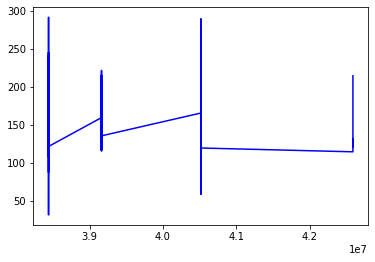

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df["session_date"],df["power_in_avg_w"], color='b')
plt.show